In [249]:
import datetime

import pandas as pd
import requests

In [250]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set_style("whitegrid")

In [251]:
url = "https://api.thegraph.com/subgraphs/name/convex-community/curve-pools"

In [252]:
id = 0
query = f"""
{{
    dailyPoolSnapshots(
        first: 1000
        where: {{poolid: "{id}"}}
        orderBy: timestamp
        orderDirection: asc
        )
    {{
        id
        poolName
        baseApr
        crvApr
        cvxApr
        tvl
        timestamp
    }}
}}
"""

In [253]:
r = requests.post(url, json={'query': query})
proposal_data = dict(r.json())
proposal_data['data']['dailyPoolSnapshots']

[{'baseApr': '0',
  'crvApr': '0',
  'cvxApr': '0',
  'id': 'compound-0-1621209600',
  'poolName': 'compound',
  'timestamp': '1621293721',
  'tvl': '102168.071237452700789558236609093'},
 {'baseApr': '0.007081292425486731961307655496601155',
  'crvApr': '0',
  'cvxApr': '0',
  'id': 'compound-0-1621296000',
  'poolName': 'compound',
  'timestamp': '1621305569',
  'tvl': '1046037.090246940418364769286259597'},
 {'baseApr': '0.05369341743568977800444863276197292',
  'crvApr': '0.001737892139960950959004528944916857',
  'cvxApr': '0.002305121889017321124346644850473862',
  'id': 'compound-0-1621382400',
  'poolName': 'compound',
  'timestamp': '1621383381',
  'tvl': '2854277.896104330465335445357870562'},
 {'baseApr': '0.04881159330696104052247520278650312',
  'crvApr': '0.01950116153535248654059552557485072',
  'cvxApr': '0.02281566964342536767267878044619257',
  'id': 'compound-0-1621468800',
  'poolName': 'compound',
  'timestamp': '1621489546',
  'tvl': '2903482.241936969973434734786

In [107]:
len(proposal_data['data']['dailyPoolSnapshots'])

132

In [120]:
pool_id = 0
pool_data = pd.DataFrame()
while True:

    query = f"""
    {{
        dailyPoolSnapshots(
            first: 1000
            where: {{poolid: "{pool_id}"}}
            orderBy: timestamp
            orderDirection: asc
            )
        {{
            poolName
            baseApr
            crvApr
            cvxApr
            tvl
            timestamp
        }}
    }}
    """

    r = requests.post(url, json={'query': query})
    proposal_data = dict(r.json())['data']['dailyPoolSnapshots']

    if not proposal_data:
        break  # end of list of all pools in subgraph

    data = pd.DataFrame(proposal_data)
    data['timestamp'] = data['timestamp'].astype(int)
    data['baseApr'] = data['baseApr'].astype(float)
    data['crvApr'] = data['crvApr'].astype(float)
    data['cvxApr'] = data['cvxApr'].astype(float)
    data['tvl'] = data['tvl'].astype(float)
    data['measurement_time'] = pd.to_datetime(data.timestamp, unit='s')
    data.set_index("measurement_time", inplace=True)

    pool_data = pool_data.append(data)
    pool_id += 1

pool_data

,baseApr,crvApr,cvxApr,poolName,timestamp,tvl
measurement_time,,,,,,
2021-05-17 23:22:01,0.000000,0.000000,0.000000,compound,1621293721,1.021681e+05
2021-05-18 02:39:29,0.007081,0.000000,0.000000,compound,1621305569,1.046037e+06
2021-05-19 00:16:21,0.053693,0.001738,0.002305,compound,1621383381,2.854278e+06
2021-05-20 05:45:46,0.048812,0.019501,0.022816,compound,1621489546,2.903482e+06
2021-05-21 03:15:09,0.028205,0.032595,0.054353,compound,1621566909,3.308910e+06
...,...,...,...,...,...,...
2021-10-20 03:15:34,0.000000,0.130959,0.243064,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634699734,2.336396e+07
2021-10-21 12:20:22,0.000046,0.134278,0.280444,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634818822,2.354891e+07
2021-10-23 05:44:08,0.000000,0.146372,0.247591,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634967848,2.360431e+07


In [121]:
pool_data['utilisation_to_incentive_ratio'] = 0
for idx, row in pool_data.iterrows():
    if row.crvApr > 0:
        pool_data.loc[idx, 'utilisation_to_incentive_ratio'] = row.baseApr / row.crvApr

pool_data

,baseApr,crvApr,cvxApr,poolName,timestamp,tvl,utilisation_to_incentive_ratio
measurement_time,,,,,,,
2021-05-17 23:22:01,0.000000,0.000000,0.000000,compound,1621293721,1.021681e+05,0.000000
2021-05-18 02:39:29,0.007081,0.000000,0.000000,compound,1621305569,1.046037e+06,0.000000
2021-05-19 00:16:21,0.053693,0.001738,0.002305,compound,1621383381,2.854278e+06,30.895713
2021-05-20 05:45:46,0.048812,0.019501,0.022816,compound,1621489546,2.903482e+06,2.503010
2021-05-21 03:15:09,0.028205,0.032595,0.054353,compound,1621566909,3.308910e+06,0.865316
...,...,...,...,...,...,...,...
2021-10-20 03:15:34,0.000000,0.130959,0.243064,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634699734,2.336396e+07,0.000000
2021-10-21 12:20:22,0.000046,0.134278,0.280444,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634818822,2.354891e+07,0.000345
2021-10-23 05:44:08,0.000000,0.146372,0.247591,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634967848,2.360431e+07,0.000000


In [156]:
pool_data.tvl = pool_data.tvl/1e6
pool_data

,baseApr,crvApr,cvxApr,poolName,timestamp,tvl,utilisation_to_incentive_ratio
measurement_time,,,,,,,
2021-05-17 23:22:01,0.000000,0.000000,0.000000,compound,1621293721,0.102168,0.000000
2021-05-18 02:39:29,0.007081,0.000000,0.000000,compound,1621305569,1.046037,0.000000
2021-05-19 00:16:21,0.053693,0.001738,0.002305,compound,1621383381,2.854278,30.895713
2021-05-20 05:45:46,0.048812,0.019501,0.022816,compound,1621489546,2.903482,2.503010
2021-05-21 03:15:09,0.028205,0.032595,0.054353,compound,1621566909,3.308910,0.865316
...,...,...,...,...,...,...,...
2021-10-20 03:15:34,0.000000,0.130959,0.243064,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634699734,23.363959,0.000000
2021-10-21 12:20:22,0.000046,0.134278,0.280444,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634818822,23.548910,0.000345
2021-10-23 05:44:08,0.000000,0.146372,0.247591,Curve.fi Factory Plain Pool: ibKRW/sKRW,1634967848,23.604306,0.000000


# Utilisation to incentives plots

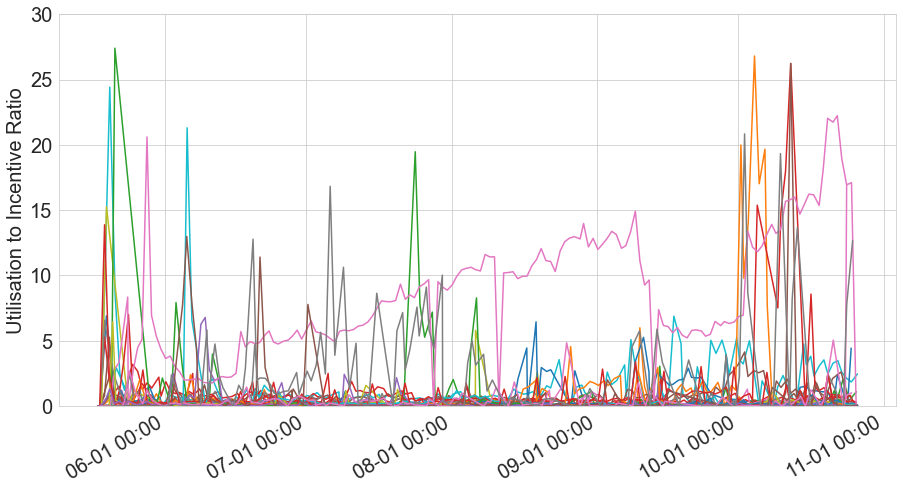

In [157]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

pruned_data = pool_data[pool_data.utilisation_to_incentive_ratio < 30]
pruned_data.groupby('poolName')['utilisation_to_incentive_ratio'].plot(legend=False, ax=ax)

ax.set_ylabel("Utilisation to Incentive Ratio", fontsize=20)
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
# _ = plt.xticks(rotation=90)

ax.set_ylim([0, 30]);

Too cluttered: take 10 day average

In [206]:
time_averaged_data = pruned_data.groupby('poolName').rolling("10d").mean()
time_averaged_data = time_averaged_data.reset_index()
time_averaged_data.set_index('measurement_time', inplace=True)
time_averaged_data.drop(columns=['tvl', 'timestamp'], inplace=True)

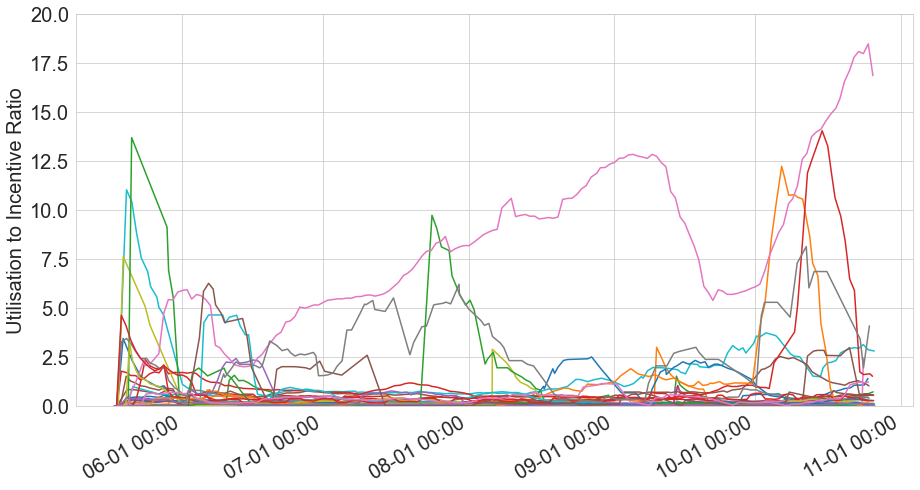

In [207]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

time_averaged_data.groupby('poolName')['utilisation_to_incentive_ratio'].plot(legend=False, ax=ax)

ax.set_ylabel("Utilisation to Incentive Ratio", fontsize=20)
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax.set_ylim([0, 20]);

Lots of pools with low utilisation but high apr it seems.

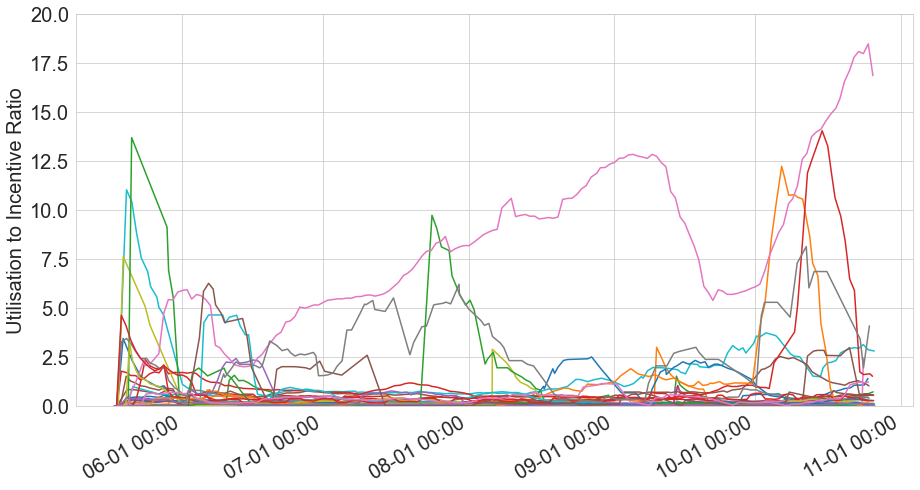

In [208]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

time_averaged_data.groupby('poolName')['utilisation_to_incentive_ratio'].plot(legend=False, ax=ax)

ax.set_ylabel("Utilisation to Incentive Ratio", fontsize=20)
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax.set_ylim([0, 20]);

In [209]:
ten_day_averages = time_averaged_data.groupby('poolName').mean().sort_values(by='utilisation_to_incentive_ratio', ascending=False)

ten_day_averages

,baseApr,crvApr,cvxApr,utilisation_to_incentive_ratio
poolName,,,,
steth,0.028138,0.004846,0.007064,7.952082
y,0.013767,0.006636,0.008180,2.966537
aave,0.037093,0.033916,0.043223,1.677650
reth,0.011559,0.038619,0.044916,1.390515
usdt,0.013820,0.024232,0.028598,1.384119
rsv,0.009365,0.084101,0.112229,1.352811
saave,0.028602,0.057643,0.074963,1.340475
aeth,0.017669,0.042483,0.058390,0.795205
compound,0.024392,0.035142,0.046306,0.760799


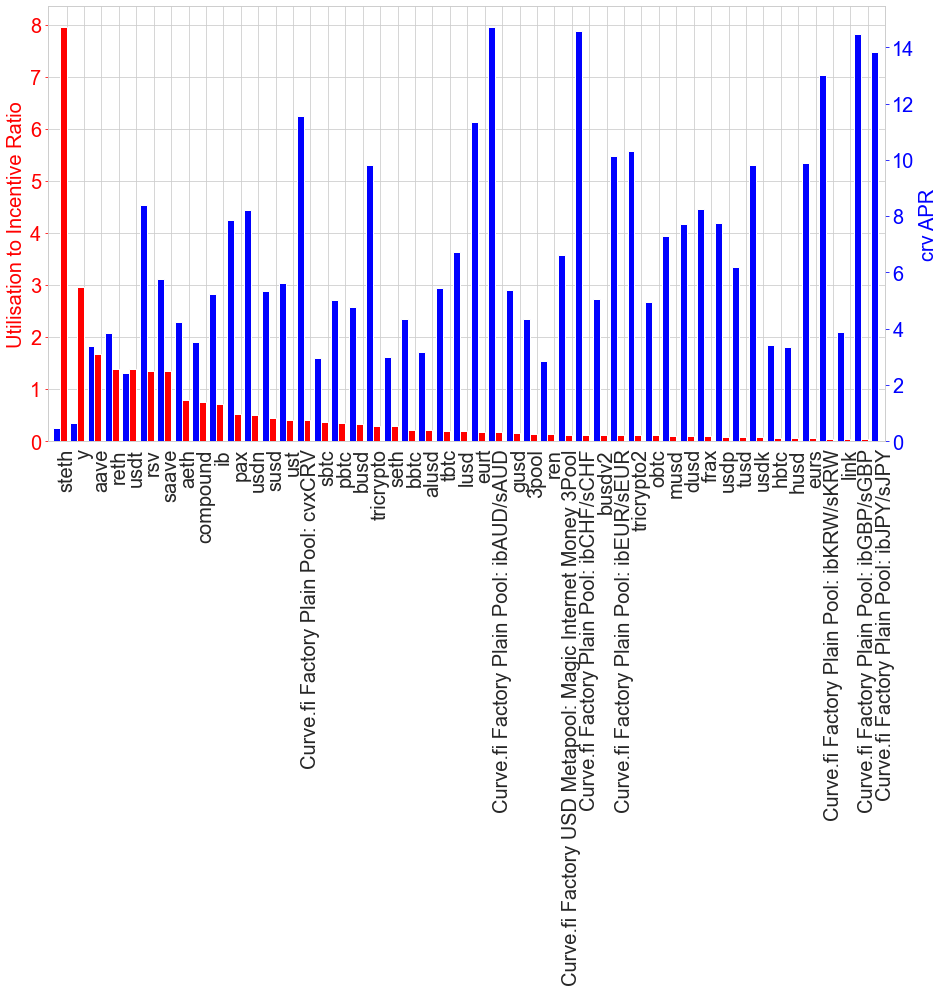

In [229]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

ten_day_averages[["utilisation_to_incentive_ratio"]].plot(
    kind='bar',
    ax=ax,
    color='red',
    width=0.4,
    position=1,
)

ax2 = ax.twinx()
(ten_day_averages[["crvApr"]] * 100).plot(
    kind='bar',
    ax=ax2,
    color='blue',
    width=0.4,
    position=2,
)

ax.get_legend().remove()
ax2.get_legend().remove()
ax2.grid(b=None)

ax.set_ylabel("Utilisation to Incentive Ratio", fontsize=20, color='red')
ax2.set_ylabel("crv APR", fontsize=20, color='blue')
ax.set_xlabel("", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='y', which='major', labelsize=20, colors='blue')

ax.tick_params(axis='y', which='major', colors='red')

Calculate the above for the past 30 days:

In [244]:
time_from = datetime.datetime.utcnow() - datetime.timedelta(days=7)
time_from

datetime.datetime(2021, 10, 19, 16, 37, 10, 584730)

In [245]:
averaged_subset = pruned_data[
    pruned_data.index > time_from
].groupby('poolName').mean()
averaged_subset.drop(columns=['tvl', 'timestamp'], inplace=True)
averaged_subset.sort_values(by='utilisation_to_incentive_ratio', inplace=True, ascending=False)
averaged_subset

,baseApr,crvApr,cvxApr,utilisation_to_incentive_ratio
poolName,,,,
steth,0.029001,0.001577,0.002712,17.003570
y,0.006526,0.001095,0.001865,5.116436
dusd,0.001430,0.048064,0.082889,4.270555
aave,0.060529,0.023504,0.040113,2.599132
ust,0.015739,0.009998,0.017156,1.870506
aeth,0.018568,0.013849,0.025909,1.602611
compound,0.046277,0.040491,0.070162,1.266712
bbtc,0.002625,0.004174,0.007387,0.924617
busd,0.035476,0.046481,0.085807,0.745230


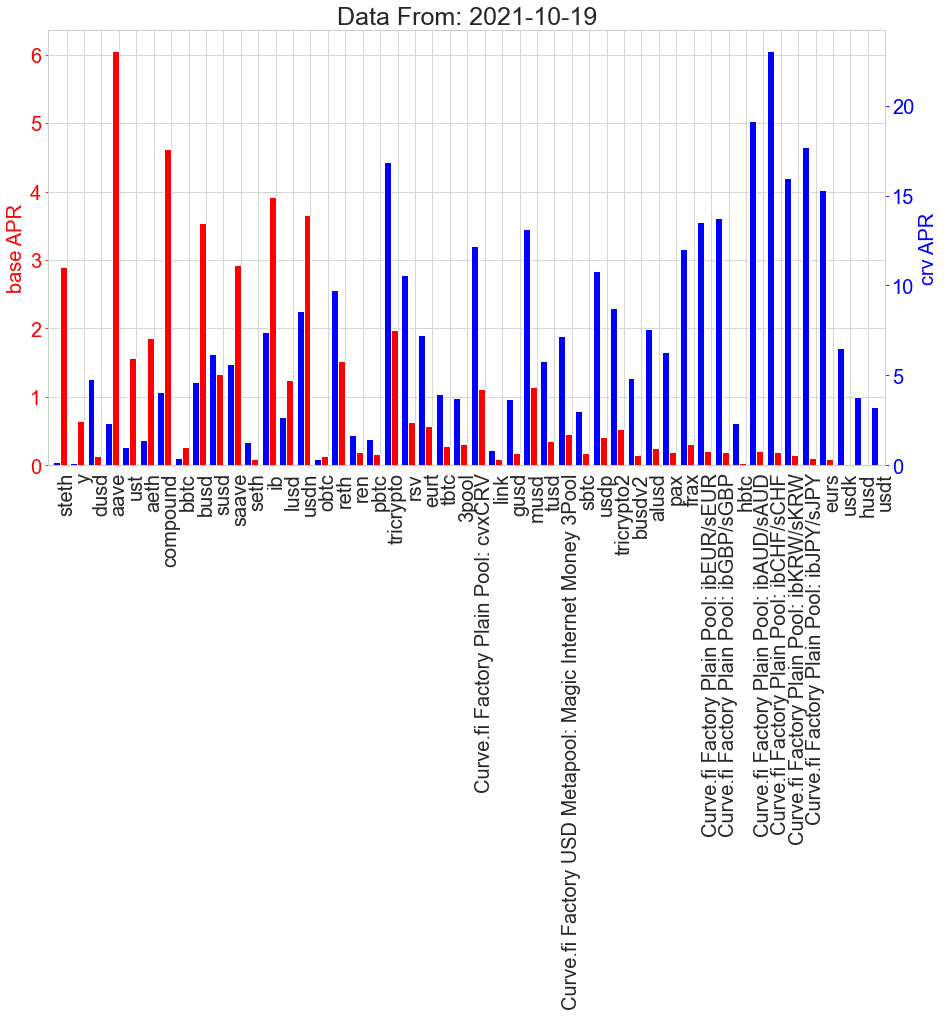

In [246]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

(averaged_subset[["baseApr"]] * 100).plot(
    kind='bar',
    ax=ax,
    color='red',
    width=0.4,
    position=1,
)

ax2 = ax.twinx()
(averaged_subset[["crvApr"]] * 100).plot(
    kind='bar',
    ax=ax2,
    color='blue',
    width=0.4,
    position=2,
)

ax.get_legend().remove()
ax2.get_legend().remove()
ax2.grid(b=None)

ax.set_ylabel("base APR", fontsize=20, color='red')
ax2.set_ylabel("crv APR", fontsize=20, color='blue')
ax.set_xlabel("", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='y', which='major', labelsize=20, colors='blue')
ax.tick_params(axis='y', which='major', colors='red')

ax.set_title(f"Data From: %s" % datetime.datetime.strftime(time_from, "%Y-%m-%d"), fontsize=25);

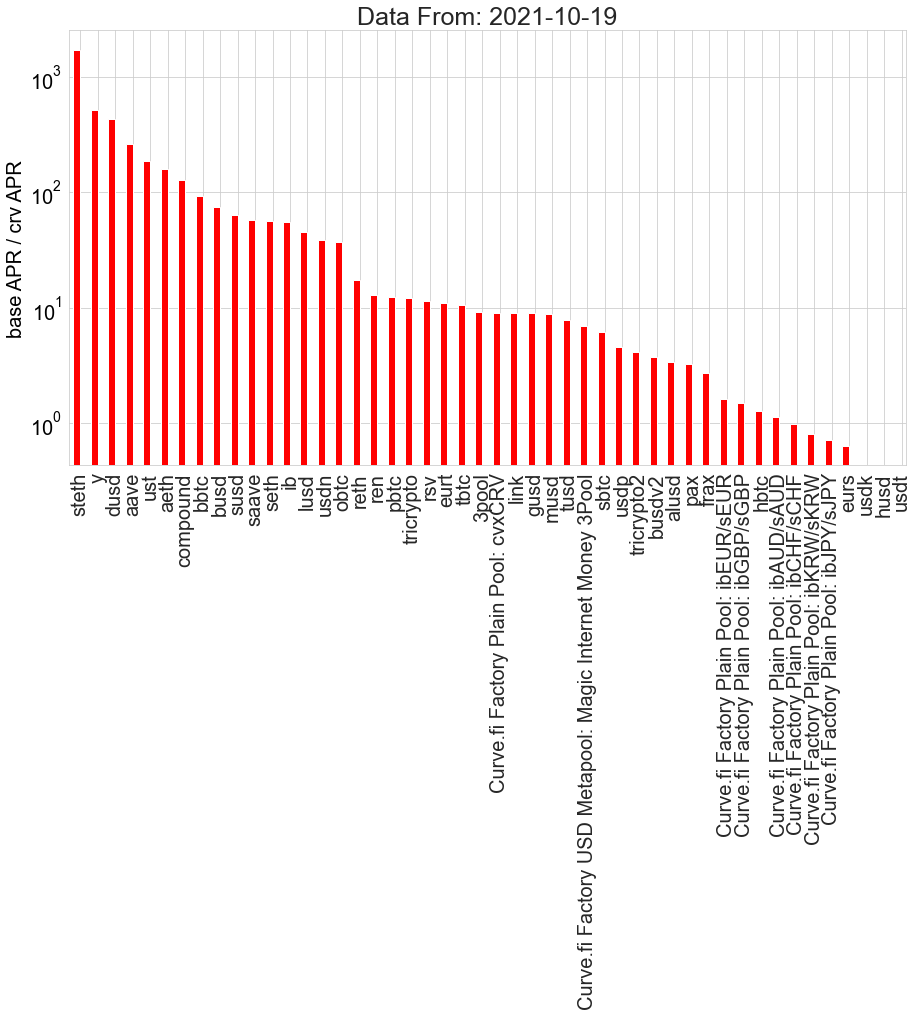

In [248]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

(averaged_subset[["utilisation_to_incentive_ratio"]] * 100).plot(
    kind='bar',
    ax=ax,
    color='red',
    width=0.4,
    position=1,
)
ax.set_yscale('log')
ax.get_legend().remove()
ax.set_ylabel("base APR / crv APR", fontsize=20, color='black')
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', colors='black')

ax.set_title(f"Data From: %s" % datetime.datetime.strftime(time_from, "%Y-%m-%d"), fontsize=25);